<a href="https://colab.research.google.com/github/rahiakela/cs231n-convolutional-neural-networks-for-visual-recognition/blob/lecture-2-image-classification/1_image_classification_using_nearest_neighbor_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Nearest Neighbor Classifier

This is an introductory lecture designed to introduce people from outside of Computer Vision to the Image Classification problem, and the data-driven approach. The Table of Contents:

* Intro to Image Classification, data-driven approach, pipeline
* Nearest Neighbor Classifier
  * k-Nearest Neighbor
* Validation sets, Cross-validation, hyperparameter tuning
* Pros/Cons of Nearest Neighbor
* Summary
* Summary: Applying kNN in practice
* Further Reading

## Setup

In [8]:
import os
import random
import platform
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# prepare dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 

--2019-12-27 10:11:14--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.2MB/s    in 11s     

2019-12-27 10:11:26 (14.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
    
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [13]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


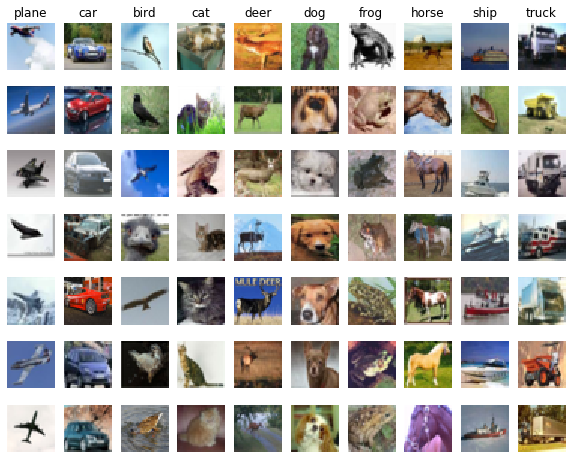

In [14]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Image Classification

### Motivation

In this section we will introduce the Image Classification problem, which is the task of assigning an input image one label from a fixed set of categories. This is one of the core problems in Computer Vision that, despite its simplicity, has a large variety of practical applications. Moreover, as we will see later in the course, many other seemingly distinct Computer Vision tasks (such as object detection, segmentation) can be reduced to image classification.



### Example

For example, in the image below an image classification model takes a single image and assigns probabilities to 4 labels, {cat, dog, hat, mug}. As shown in the image, keep in mind that to a computer an image is represented as one large 3-dimensional array of numbers. In this example, the cat image is 248 pixels wide, 400 pixels tall, and has three color channels Red,Green,Blue (or RGB for short). Therefore, the image consists of 248 x 400 x 3 numbers, or a total of 297,600 numbers. Each number is an integer that ranges from 0 (black) to 255 (white). Our task is to turn this quarter of a million numbers into a single label, such as “cat”.


---

<img src='http://cs231n.github.io/assets/classify.png?raw=1' width='800'/>

The task in Image Classification is to predict a single label (or a distribution over labels as shown here to indicate our confidence) for a given image. Images are 3-dimensional arrays of integers from 0 to 255, of size Width x Height x 3. The 3 represents the three color channels Red, Green, Blue.


---

### Challenges

Since this task of recognizing a visual concept (e.g. cat) is relatively trivial for a human to perform, it is worth considering the challenges involved from the perspective of a Computer Vision algorithm. As we present (an inexhaustive) list of challenges below, keep in mind the raw representation of images as a 3-D array of brightness values:

* **Viewpoint variation**. A single instance of an object can be oriented in many ways with respect to the camera.
* **Scale variation**. Visual classes often exhibit variation in their size (size in the real world, not only in terms of their extent in the image).
* **Deformation**. Many objects of interest are not rigid bodies and can be deformed in extreme ways.
* **Occlusion**. The objects of interest can be occluded. Sometimes only a small portion of an object (as little as few pixels) could be visible.
* **Illumination conditions**. The effects of illumination are drastic on the pixel level.
* **Background clutter**. The objects of interest may blend into their environment, making them hard to identify.
* **Intra-class variation**. The classes of interest can often be relatively broad, such as chair. There are many different types of these objects, each with their own appearance.

A good image classification model must be invariant to the cross product of all these variations, while simultaneously retaining sensitivity to the inter-class variations.


---

<img src='http://cs231n.github.io/assets/challenges.jpeg?raw=1' width='800'/>


---



### Data-driven approach

How might we go about writing an algorithm that can classify images into distinct categories? Unlike writing an algorithm for, for example, sorting a list of numbers, it is not obvious how one might write an algorithm for identifying cats in images. Therefore, instead of trying to specify what every one of the categories of interest look like directly in code, the approach that we will take is not unlike one you would take with a child: we’re going to provide the computer with many examples of each class and then develop learning algorithms that look at these examples and learn about the visual appearance of each class. This approach is referred to as a data-driven approach, since it relies on first accumulating a training dataset of labeled images. Here is an example of what such a dataset might look like:


---
<img src='http://cs231n.github.io/assets/trainset.jpg?raw=1' width='800'/>

An example training set for four visual categories. In practice we may have thousands of categories and hundreds of thousands of images for each category.


---




### The image classification pipeline

We’ve seen that the task in Image Classification is to take an array of pixels that represents a single image and assign a label to it. Our complete pipeline can be formalized as follows:

* **Input**: Our input consists of a set of N images, each labeled with one of K different classes. We refer to this data as the training set.
* **Learning**: Our task is to use the training set to learn what every one of the classes looks like. We refer to this step as training a classifier, or learning a model.
* **Evaluation**: In the end, we evaluate the quality of the classifier by asking it to predict labels for a new set of images that it has never seen before. We will then compare the true labels of these images to the ones predicted by the classifier. Intuitively, we’re hoping that a lot of the predictions match up with the true answers (which we call the ground truth).

## Nearest Neighbor Classifier

As our first approach, we will develop what we call a **Nearest Neighbor Classifier**. This classifier has nothing to do with Convolutional Neural Networks and it is very rarely used in practice, but it will allow us to get an idea about the basic approach to an image classification problem.

### Example image classification dataset: CIFAR-10

One popular toy image classification dataset is the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60,000 tiny images that are 32 pixels high and wide. Each image is labeled with one of 10 classes (for example “airplane, automobile, bird, etc”). These 60,000 images are partitioned into a training set of 50,000 images and a test set of 10,000 images. In the image below you can see 10 random example images from each one of the 10 classes:


---
<img src='http://cs231n.github.io/assets/nn.jpg?raw=1' width='800'/>
Left: Example images from the CIFAR-10 dataset. Right: first column shows a few test images and next to each we show the top 10 nearest neighbors in the training set according to pixel-wise difference.
---
Suppose now that we are given the CIFAR-10 training set of 50,000 images (5,000 images for every one of the labels), and we wish to label the remaining 10,000. The nearest neighbor classifier will take a test image, compare it to every single one of the training images, and predict the label of the closest training image. In the image above and on the right you can see an example result of such a procedure for 10 example test images. Notice that in only about 3 out of 10 examples an image of the same class is retrieved, while in the other 7 examples this is not the case. For example, in the 8th row the nearest training image to the horse head is a red car, presumably due to the strong black background. As a result, this image of a horse would in this case be mislabeled as a car.

You may have noticed that we left unspecified the details of exactly how we compare two images, which in this case are just two blocks of 32 x 32 x 3. One of the simplest possibilities is to compare the images pixel by pixel and add up all the differences. In other words, given two images and representing them as vectors **I1,I2** , a reasonable choice for comparing them might be the **L1 distance**:
<img src='https://github.com/rahiakela/img-repo/blob/master/l2-distance.PNG?raw=1' width='800'/>

Where the sum is taken over all pixels. Here is the procedure visualized:


---
<img src='http://cs231n.github.io/assets/nneg.jpeg?raw=1' width='800'/>
An example of using pixel-wise differences to compare two images with L1 distance (for one color channel in this example). Two images are subtracted elementwise and then all differences are added up to a single number. If two images are identical the result will be zero. But if the images are very different the result will be large.

---

Let’s also look at how we might implement the classifier in code. First, let’s load the CIFAR-10 data into memory as 4 arrays: the training data/labels and the test data/labels. In the code below, **X_train** (of size 50,000 x 32 x 32 x 3) holds all the images in the training set, and a corresponding 1-dimensional array **Y_train** (of length 50,000) holds the training labels (from 0 to 9):


In [0]:
X_train, Y_train, X_test, Y_test = load_CIFAR10('cifar-10-batches-py/')

# flatten out all images to be one-dimensional
Xtrain_rows = X_train.reshape(X_train.shape[0], 32 * 32 * 3)  # Xtrain_rows becomes 50000 x 3072
Xtest_rows = X_test.reshape(X_test.shape[0], 32 * 32 * 3)     # Xtest_rows becomes 10000 x 3072

In [16]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Now that we have all images stretched out as rows, here is how we could train and evaluate a classifier:

```python
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(Xtrain_rows, Y_train) # train the classifier on the training images and labels
Y_test_predict = nn.predict(Xtest_rows) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print 'accuracy: %f' % ( np.mean(Y_test_predict == Y_test) )
```

Notice that as an evaluation criterion, it is common to use the **accuracy**, which measures the fraction of predictions that were correct. Notice that all classifiers we will build satisfy this one common API: they have a **train(X,y)** function that takes the data and the labels to learn from. Internally, the class should build some kind of model of the labels and how they can be predicted from the data. And then there is a **predict(X)** function, which takes new data and predicts the labels. Of course, we’ve left out the meat of things - the actual classifier itself. Here is an implementation of a simple Nearest Neighbor classifier with the L1 distance that satisfies this template:

In [0]:
class NearestNeighbor(object):

  def __init__(self):
    pass

  
  def train(self, X, y):
    '''X is N x D where each row is an example. Y is 1-dimension of size N'''
    # the nearest neighbor classifier simply remembers all the training data
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    '''X is N x D where each row is an example we wish to predict label for'''
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    y_pred = np.zeros(num_test, dtype=self.y_train.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.X_train - X[i, :]), axis=1)
      min_index = np.argmin(distances)       # get the index with smallest distance
      y_pred[i] = self.y_train[min_index]    # predict the label of the nearest example

    return y_pred

If you ran this code, you would see that this classifier only achieves 38.6% on CIFAR-10. That’s more impressive than guessing at random (which would give 10% accuracy since there are 10 classes), but nowhere near human performance (which is [estimated at about 94%](http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/)) or near state-of-the-art Convolutional Neural Networks that achieve about 95%, matching human accuracy (see the [leaderboard](https://www.kaggle.com/c/cifar-10/leaderboard) of a recent Kaggle competition on CIFAR-10).

In [0]:
# create a Nearest Neighbor classifier class
nn = NearestNeighbor()     

# train the classifier on the training images and labels
nn.train(Xtrain_rows, Y_train)

# predict labels on the test images
y_test_predict = nn.predict(Xtest_rows)

# now print the classification accuracy, which is the average number of examples that are correctly predicted (i.e. label matches)
print(f'Accuracy : {str(np.mean(y_test_predict == Y_test))}')

Accuracy : 0.3859


### The choice of distance

There are many other ways of computing distances between vectors. Another common choice could be to instead use the **L2 distance**, which has the geometric interpretation of computing the euclidean distance between two vectors. The distance takes the form:
<img src='https://github.com/rahiakela/img-repo/blob/master/l22-distance.PNG?raw=1' width='800'/>

In other words we would be computing the pixelwise difference as before, but this time we square all of them, add them up and finally take the square root. In numpy, using the code from above we would need to only replace a single line of code. The line that computes the distances:

```pythin
distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
```
Note that I included the **np.sqrt** call above, but in a practical nearest neighbor application we could leave out the square root operation because square root is a monotonic function. That is, it scales the absolute sizes of the distances but it preserves the ordering, so the nearest neighbors with or without it are identical. If you ran the Nearest Neighbor classifier on CIFAR-10 with this distance, you would obtain **35.4%** accuracy (slightly lower than our L1 distance result).

### L1 vs. L2

 It is interesting to consider differences between the two metrics. In particular, the L2 distance is much more unforgiving than the L1 distance when it comes to differences between two vectors. That is, the L2 distance prefers many medium disagreements to one big one. L1 and L2 distances (or equivalently the L1/L2 norms of the differences between a pair of images) are the most commonly used special cases of a [p-norm](https://planetmath.org/vectorpnorm).

## k - Nearest Neighbor Classifier

You may have noticed that it is strange to only use the label of the nearest image when we wish to make a prediction. Indeed, it is almost always the case that one can do better by using what’s called a **k-Nearest Neighbor Classifier**. The idea is very simple: instead of finding the single closest image in the training set, we will find the top **k** closest images, and have them vote on the label of the test image. In particular, when k = 1, we recover the Nearest Neighbor classifier. Intuitively, higher values of **k** have a smoothing effect that makes the classifier more resistant to outliers:

---

<img src='http://cs231n.github.io/assets/knn.jpeg?raw=1' width='800'/>

An example of the difference between Nearest Neighbor and a 5-Nearest Neighbor classifier, using 2-dimensional points and 3 classes (red, blue, green). The colored regions show the decision boundaries induced by the classifier with an L2 distance. The white regions show points that are ambiguously classified (i.e. class votes are tied for at least two classes). Notice that in the case of a NN classifier, outlier datapoints (e.g. green point in the middle of a cloud of blue points) create small islands of likely incorrect predictions, while the 5-NN classifier smooths over these irregularities, likely leading to better generalization on the test data (not shown). Also note that the gray regions in the 5-NN image are caused by ties in the votes among the nearest neighbors (e.g. 2 neighbors are red, next two neighbors are blue, last neighbor is green).

---
In practice, you will almost always want to use k-Nearest Neighbor. But what value of k should you use? We turn to this problem next.




### Validation sets for Hyperparameter tuning

The k-nearest neighbor classifier requires a setting for k. But what number works best? Additionally, we saw that there are many different distance functions we could have used: L1 norm, L2 norm, there are many other choices we didn’t even consider (e.g. dot products). These choices are called **hyperparameters** and they come up very often in the design of many Machine Learning algorithms that learn from data. It’s often not obvious what values/settings one should choose.

You might be tempted to suggest that we should try out many different values and see what works best. That is a fine idea and that’s indeed what we will do, but this must be done very carefully. In particular, **we cannot use the test set for the purpose of tweaking hyperparameters**. Whenever you’re designing Machine Learning algorithms, you should think of the test set as a very precious resource that should ideally never be touched until one time at the very end. Otherwise, the very real danger is that you may tune your hyperparameters to work well on the test set, but if you were to deploy your model you could see a significantly reduced performance. In practice, we would say that you **overfit** to the test set. Another way of looking at it is that if you tune your hyperparameters on the test set, you are effectively using the test set as the training set, and therefore the performance you achieve on it will be too optimistic with respect to what you might actually observe when you deploy your model. But if you only use the test set once at end, it remains a good proxy for measuring the **generalization** of your classifier

**Evaluate on the test set only a single time, at the very end.**

Luckily, there is a correct way of tuning the hyperparameters and it does not touch the test set at all. The idea is to split our training set in two: a slightly smaller training set, and what we call a **validation set**. Using CIFAR-10 as an example, we could for example use 49,000 of the training images for training, and leave 1,000 aside for validation. This validation set is essentially used as a fake test set to tune the hyper-parameters.

Here is what this might look like in the case of CIFAR-10:

In [0]:
class KNearestNeighbor(object):

  def __init__(self):
    pass

  
  def train(self, X, y):
    '''X is N x D where each row is an example. Y is 1-dimension of size N'''
    # the nearest neighbor classifier simply remembers all the training data
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    '''
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
          of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    '''
    
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      ValueError(f'Invalid value {str(num_loops)} for num_loops')

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    '''
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    '''
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    for i in range(num_test):
      for j in range(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension, nor use np.linalg.norm().          #
        #####################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dists[i, j] = np.sqrt(np.sum(np.square(X[i, :] - self.X_train[j, :]), axis=1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists

  def compute_distances_one_loop(self, X):
    '''
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    '''
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    for i in range(num_test):
        #######################################################################
        # TODO:                                                               #
        # Compute the l2 distance between the ith test point and all training #
        # points, and store the result in dists[i, :].                        #
        # Do not use np.linalg.norm().                                        #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dists[i, :] = np.sqrt(np.sum(np.square(X[i] - self.X_train), axis=1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists


  def compute_distances_no_loops(self, X):
    '''
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    '''

    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy,                #
    # nor use np.linalg.norm().                                             #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # dists[:, :] = np.sqrt(np.sum(np.square(X[:, :] - self.X_train[:, :]), axis=1))
    dists = np.reshape(np.sum(X**2, axis=1), [num_test,1]) + np.sum(self.X_train**2, axis=1) - 2 * np.matmul(X, self.X_train.T)
    dists = np.sqrt(dists)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists

  def predict_labels(self, dists, k=1):
    '''
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    '''

    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to the ith test point.
      closest_y = []

      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

      closest_y = self.y_train[np.argsort(dists[0])][0:k]

      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

      y_pred[i] = np.bincount(closest_y).argmax()

      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return y_pred

In [24]:
# assume we have Xtr_rows, Ytr, Xte_rows, Yte as before
# recall Xtr_rows is 50,000 x 3072 matrix
Xval_rows = Xtrain_rows[:1000, :]          # take first 1000 for validation
Yval = Y_train[:1000]

Xtr_rows = Xtrain_rows[1000:, :]           # keep last 49,000 for train
Ytr = Y_train[1000:]

# find hyperparameters that work best on the validation set
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:
  # use a particular value of k and evaluation on validation data
  knn = KNearestNeighbor()
  knn.train(Xtr_rows, Ytr)

  # here we use KNearestNeighbor class that can take a k as input
  Yval_predict = knn.predict(Xval_rows, k=k)
  acc = np.mean(Yval_predict == Yval)
  print(f'accuracy : {str(acc)}')

  # keep track of what works on the validation set
  validation_accuracies.append((k, acc))

validation_accuracies

accuracy : 0.099
accuracy : 0.099
accuracy : 0.099
accuracy : 0.099
accuracy : 0.099
accuracy : 0.099
accuracy : 0.099


[(1, 0.099),
 (3, 0.099),
 (5, 0.099),
 (10, 0.099),
 (20, 0.099),
 (50, 0.099),
 (100, 0.099)]